# Road Accident Dataset - EDA y Pipelines de preprocesamiento

## Introducción

En este notebook realizaremos análisis exploratorio de datos en el dataset de road accident para posteriormente construir un pipeline de preprocesamiento para las características numéricas y categóricas.

El dataset contiene información sobre múltiples vías de tránsito vehicular, con información que va desde el tipo de vía, el número de carriles, la curvatura, la velocidad máxima permitida, la presencia o ausencia de señalamientos viales, si es público o privado, si hay reportes de accidentes, y las distintas condiciones en las que estos pueden ocurrir, con una etiqueta del riesgo calculado para cada configuración.

El objetivo y problema a resolver es predecir el riesgo de transitar en ciertas condiciones una vía vehicular encuadrándole exclusivamente en las características de entrada de este modelo, haciendo de esto una regresión. El dataset se puede encontrar en el siguiente enlace de Kaggle: https://www.kaggle.com/datasets/chetanmittal033/road-accident-dataset

Este dataset viene ya dividido en datos de entrenamiento y datos de prueba, para efectos de mimetizar el proceso visto en clase, los unificaré.

Comenzaremos importando las librerías necesarias y cargando el dataset como un DataFrame de pandas.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer

In [2]:
og_train = pd.read_csv('./datasets/road_accident_train.csv')
og_test = pd.read_csv('./datasets/road_accident_test.csv')
data = pd.concat([og_train, og_test], ignore_index=True)

data

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690334,690334,rural,2,0.01,45,dim,rainy,False,False,afternoon,True,True,2,NaN
690335,690335,rural,1,0.74,70,daylight,foggy,False,True,afternoon,False,False,2,NaN
690336,690336,urban,2,0.14,70,dim,clear,False,False,evening,True,True,1,NaN
690337,690337,urban,1,0.09,45,daylight,foggy,True,True,morning,False,True,0,NaN


## Información básica y estadísticas

Utilizaremos el método `.info()` para obtener un vistazo rápido al dataset, incluyendo el número de entradas no nulas y su tipo.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690339 entries, 0 to 690338
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      690339 non-null  int64  
 1   road_type               690339 non-null  object 
 2   num_lanes               690339 non-null  int64  
 3   curvature               690339 non-null  float64
 4   speed_limit             690339 non-null  int64  
 5   lighting                690339 non-null  object 
 6   weather                 690339 non-null  object 
 7   road_signs_present      690339 non-null  bool   
 8   public_road             690339 non-null  bool   
 9   time_of_day             690339 non-null  object 
 10  holiday                 690339 non-null  bool   
 11  school_season           690339 non-null  bool   
 12  num_reported_accidents  690339 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

De igual forma, obtenemos estadísticas resumidas para las columnas numéricas con el método `.describe()`. Lo transpondremos para mejorar la legibilidad.

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,690339.0,345169.000000,199283.848079,0.0,172584.50,345169.00,517753.50,690338.0
num_lanes,690339.0,2.492145,1.120113,1.0,1.00,2.00,3.00,4.0
curvature,690339.0,0.488355,0.272509,0.0,0.26,0.51,0.71,1.0
speed_limit,690339.0,46.110121,15.788149,25.0,35.00,45.00,60.00,70.0
num_reported_accidents,690339.0,1.187492,0.896261,0.0,1.00,1.00,2.00,7.0
accident_risk,517754.0,0.352377,0.166417,0.0,0.23,0.34,0.46,1.0


En total contamos con **14 columnas**:

- **id**: Identificador único de cada observación (muestra).
- **road_type**: Tipo de vialidad analizada (por ejemplo, carretera, vía urbana), representado como valores de tipo cadena.
- **num_lanes**: Número de carriles de la vía.
- **curvature**: Grado de curvatura de la carretera, expresado como un valor numérico continuo.
- **speed_limit**: Límite legal de velocidad de la vía.
- **lighting**: Tipo de condiciones de iluminación presentes en la vía, representado como valores de tipo cadena.
- **weather**: Condiciones climáticas en el momento de la observación, representadas como valores de tipo cadena.
- **road_signs_present**: Valor booleano que indica si existen señales o letreros viales.
- **public_road**: Valor booleano que indica si la vía es pública (es decir, no es de peaje).
- **time_of_day**: Categoría de la hora del día en la que se tomó la muestra, representada como valores de tipo cadena.
- **holiday**: Valor booleano que indica si la observación se realizó en un día festivo.
- **school_season**: Valor booleano que indica si la observación ocurrió durante la temporada escolar.
- **num_reported_accidents**: Número entero de accidentes reportados para la vía bajo las condiciones descritas.
- **accident_risk**: Etiqueta objetivo que representa la probabilidad estimada de que ocurra un accidente automovilístico bajo estas condiciones, expresada como un valor continuo entre 0 y 1.

Cabe destacar que la columna **accident_risk** contiene valores faltantes, mientras que el resto de las columnas están completas para todas las observaciones; estos datos vienen de la subsección de test original.

Para efectos de nuestro análisis, emplearemos todas las características, salvo id, ya que id es distinto para cada uno de los elementos y nada más representa el identificador acumulativo dentro de nuestra tabla de muestras.

La columna accident_risk será nuestra etiqueta objetivo.

## Visualización de características numéricas

Para visualizar las distribuciones, usaremos la librería `seaborn`, creando histogramas con densidad de kernel y estimados KDE para cada columna numérica no categórica, es decir, para curvature. Se consideró que las columnas discretas como 'num_lanes', 'speed_limit' y 'num_reported_accidents' comprenden categorías por su dominio tan estrecho.

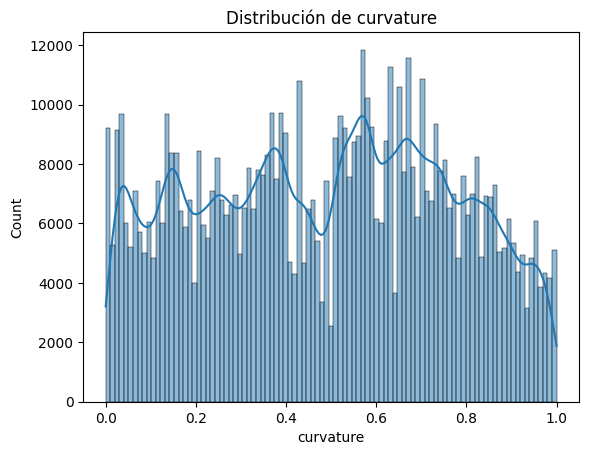

In [5]:
numerical_cols = ['curvature']

plt.plot(figsize=(12, 8))
sns.histplot(data, x='curvature', kde=True)
plt.title(f'Distribución de curvature')
plt.show()

Como puede observarse, la distribución de *curvature* se extiende a lo largo de todo su rango sin concentrarse de manera extrema en un solo sector. Los valores presentan variaciones suaves, con ligeros picos intermedios, pero sin una inclinación marcada hacia alguno de los extremos. Tampoco se aprecian valores desproporcionadamente altos que dominen el comportamiento general de los datos.

Debido a la magnitud de los valores, se utilizará Standard Scaler.

## Visualización de las características categóricas

Revisaremos la distribución de las características categóricas con Countplots.

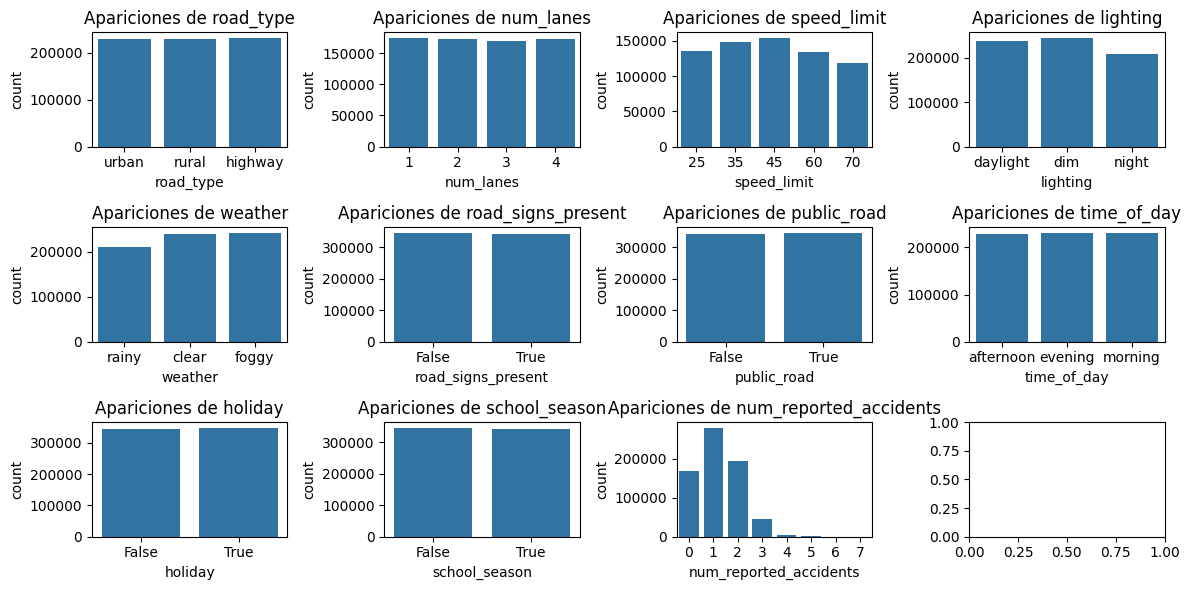

In [6]:
categorical_cols = ['road_type', 'num_lanes', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents']

fig, axs = plt.subplots(3, 4, figsize=(12, 6))

for ax, col in zip(axs.ravel(), categorical_cols):
    sns.countplot(data=data, x=col, ax=ax)
    ax.set_title(f'Apariciones de {col}')

fig.tight_layout()

Como se aprecia en las gráficas, las variables categóricas del conjunto de datos muestran distribuciones en general equilibradas, sin dominancias extremas que indiquen una sobrerrepresentación problemática de alguna categoría específica. En el caso de *road_type*, las observaciones se reparten de manera bastante uniforme entre vías urbanas, rurales y carreteras, lo que sugiere una cobertura amplia de distintos entornos viales. Algo similar ocurre con *num_lanes*, donde los valores entre uno y cuatro carriles presentan frecuencias comparables, sin que un número de carriles destaque de forma desproporcionada.

Para *speed_limit* se observa una variación más marcada entre categorías, aunque sin un sesgo extremo: los límites intermedios concentran ligeramente más observaciones que los valores más bajos o más altos. En cuanto a *lighting*, las condiciones de luz diurna y luz tenue aparecen con frecuencias similares, mientras que la categoría nocturna es algo menos común, aunque sigue estando bien representada. El comportamiento de *weather* es comparable, con una distribución relativamente balanceada entre condiciones lluviosas, despejadas y con niebla.

Las variables booleanas también muestran una división cercana al equilibrio. Tanto *road_signs_present* como *public_road* presentan proporciones similares entre valores verdaderos y falsos, lo que indica que el conjunto incluye tanto vías con y sin señalización, así como carreteras públicas y no públicas, sin un predominio claro de alguna condición. De manera análoga, *holiday* y *school_season* se reparten de forma casi simétrica, sugiriendo que las muestras abarcan tanto periodos festivos como no festivos, y temporadas escolares y no escolares, con una cobertura comparable.

En *time_of_day* se aprecia nuevamente una distribución homogénea entre mañana, tarde y noche, lo que reduce el riesgo de que el modelo aprenda patrones condicionados por una franja horaria dominante. Por último, *num_reported_accidents* presenta un patrón distinto al resto: los valores bajos son claramente más frecuentes, mientras que los conteos altos aparecen de forma decreciente, lo cual es consistente con la expectativa de que la mayoría de los tramos registren pocos accidentes y solo unos cuantos acumulen cifras mayores.

De cara al preprocesamiento, las variables categóricas representadas como texto requieren ser transformadas a un formato numérico adecuado para su uso en modelos predictivos. Una codificación por indicadores resulta apropiada para conservar la información de cada categoría sin imponer relaciones artificiales entre ellas, especialmente dado que las distribuciones son relativamente balanceadas y no sugieren la necesidad de agrupar o eliminar categorías por escasez de datos.

## Distribución de la etiqueta objetivo

A continuación tenemos los datos de accident_risk analizados en una distribución.

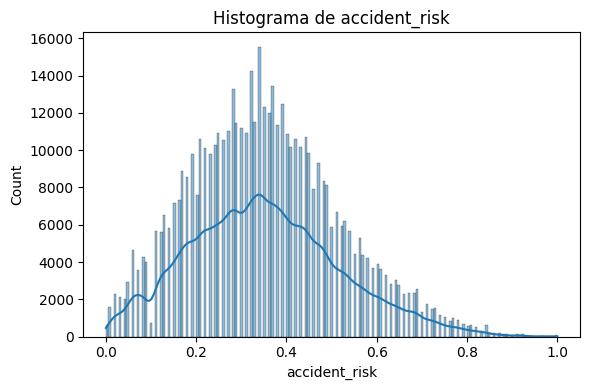

In [7]:
fig = plt.figure(figsize=(6, 4))
sns.histplot(data=data, x='accident_risk', kde=True)
plt.title('Histograma de accident_risk')
plt.tight_layout()

Comparemos con las características categóricas.

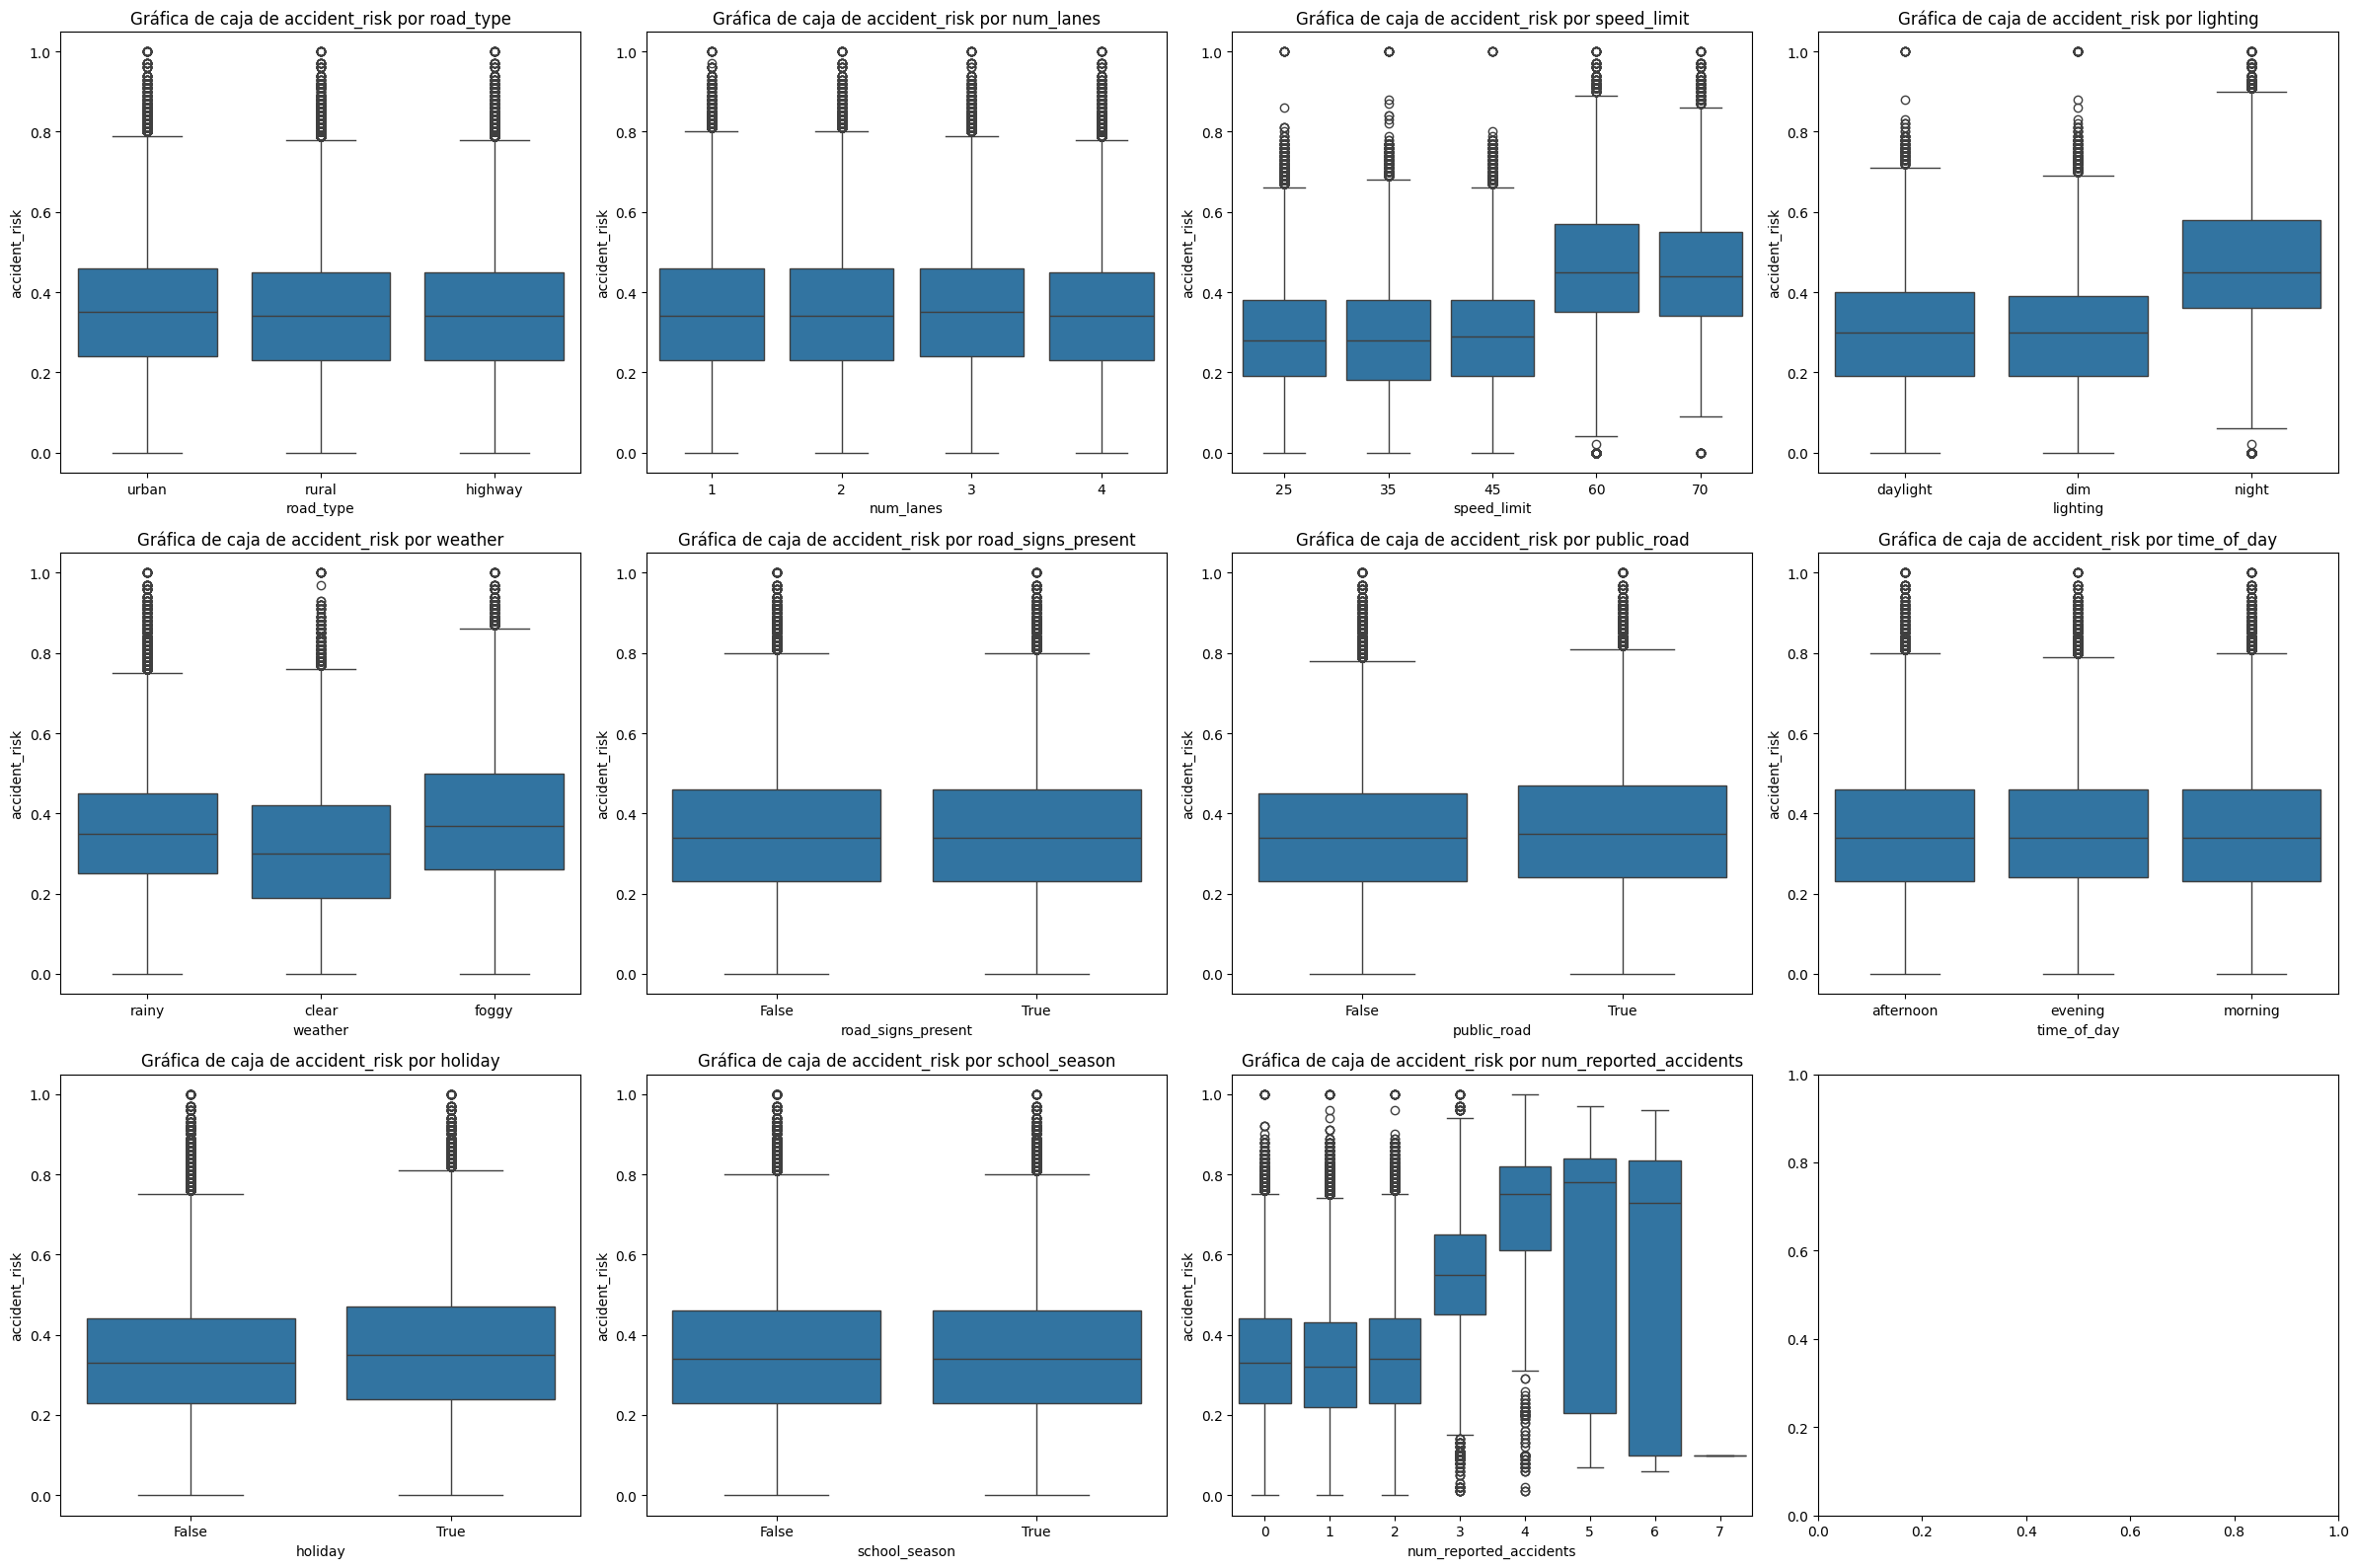

In [8]:
fig, axs = plt.subplots(3, 4, figsize=(24, 16))

for ax, col in zip(axs.ravel(), categorical_cols):
    sns.boxplot(data=data, y='accident_risk', x=col, ax=ax)
    ax.set_title(f'Gráfica de caja de accident_risk por {col}')

fig.tight_layout()

Al observar las gráficas de caja, se aprecia que el valor de *accident_risk* mantiene, en muchos casos, una mediana y un rango intercuartílico similares entre distintas categorías, lo que sugiere que varias de estas variables no introducen cambios drásticos por sí solas. En *road_type*, por ejemplo, las distribuciones para vías urbanas, rurales y carreteras son muy cercanas entre sí, con dispersiones comparables y sin desplazamientos claros que indiquen un tipo de vialidad claramente más riesgoso que los demás.

Algo semejante ocurre con *num_lanes*, donde el riesgo se mantiene relativamente estable al pasar de uno a cuatro carriles, con variaciones leves pero sin una tendencia consistente que apunte a un incremento o disminución marcada. En contraste, *speed_limit* muestra una separación más evidente: las categorías con límites más altos concentran medianas superiores y una dispersión mayor, lo que indica que, conforme aumenta el límite de velocidad, el riesgo tiende a desplazarse hacia valores más altos y a volverse más variable.

Las condiciones de *lighting* también presentan diferencias claras. Durante el día y con iluminación tenue, el riesgo se concentra en valores más bajos, mientras que la categoría nocturna exhibe una mediana más elevada y una dispersión mayor, acompañada de valores altos más frecuentes. En *weather*, aunque las tres condiciones comparten rangos similares, la presencia de niebla parece asociarse con valores centrales ligeramente más altos que en clima despejado, quedando la lluvia en un punto intermedio.

En el caso de *road_signs_present* y *public_road*, las diferencias entre categorías son sutiles. Las medianas son muy cercanas, aunque se observa una ligera elevación del riesgo cuando hay señalización y cuando la vía es pública, acompañada también de una dispersión algo mayor. *time_of_day* mantiene un comportamiento bastante homogéneo entre mañana, tarde y noche, sin desplazamientos pronunciados, lo que sugiere que la hora del día, por sí misma, no introduce una separación fuerte en el riesgo.

Las variables *holiday* y *school_season* muestran diferencias moderadas. En ambos casos, las observaciones asociadas a valores verdaderos presentan medianas ligeramente más altas y colas superiores algo más largas, lo que apunta a un incremento moderado del riesgo en esos periodos, aunque sin rupturas claras respecto a los casos opuestos.

Finalmente, *num_reported_accidents* destaca de manera evidente frente al resto. A medida que el número de accidentes reportados aumenta, la distribución del riesgo se desplaza claramente hacia valores más altos, con medianas crecientes y rangos amplios. Esta relación es mucho más marcada que en cualquier otra variable, lo que indica que aquí sí existe una separación fuerte y consistente entre categorías, reflejando un vínculo directo entre el historial de accidentes y el nivel de riesgo estimado.

Y para la única característica numérica.

<Figure size 2400x2400 with 0 Axes>

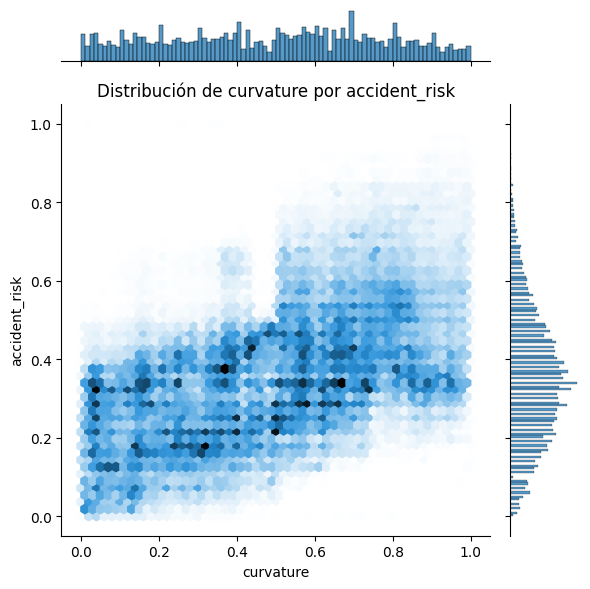

In [9]:
plt.figure(figsize=(24, 24))
sns.jointplot(data, x='curvature', y='accident_risk', kind='hex')
plt.title(f'Distribución de curvature por accident_risk')
plt.tight_layout()


La gráfica muestra una relación clara, aunque no estrictamente lineal, entre *curvature* y *accident_risk*. A valores bajos de curvatura, el riesgo se concentra mayoritariamente en niveles bajos y medios, con una dispersión relativamente contenida. Conforme la curvatura aumenta, la nube de puntos se desplaza gradualmente hacia valores más altos de riesgo y, al mismo tiempo, se ensancha, lo que indica una mayor variabilidad en los resultados asociados a curvaturas elevadas.

No se observa una frontera nítida que separe zonas de bajo y alto riesgo, sino más bien un gradiente continuo en el que el incremento de la curvatura amplía el rango de valores posibles de *accident_risk*. En los valores intermedios de curvatura aparece una concentración más densa de observaciones, lo que sugiere que gran parte de los casos se sitúan en ese intervalo, mientras que los extremos presentan menor densidad relativa.

La distribución marginal refuerza esta lectura: *curvature* se reparte de forma amplia a lo largo de su rango, y *accident_risk* se concentra principalmente en valores bajos y medios, con una cola que se extiende hacia valores altos. En conjunto, el patrón observado sugiere que una mayor curvatura está asociada con un aumento tanto del nivel típico de riesgo como de su dispersión, sin que ello implique una relación determinista, sino una tendencia general modulada por otros factores no visibles en esta proyección.

A continuación se muestra una matriz de correlación entre las características con valores numéricos y la etiqueta.

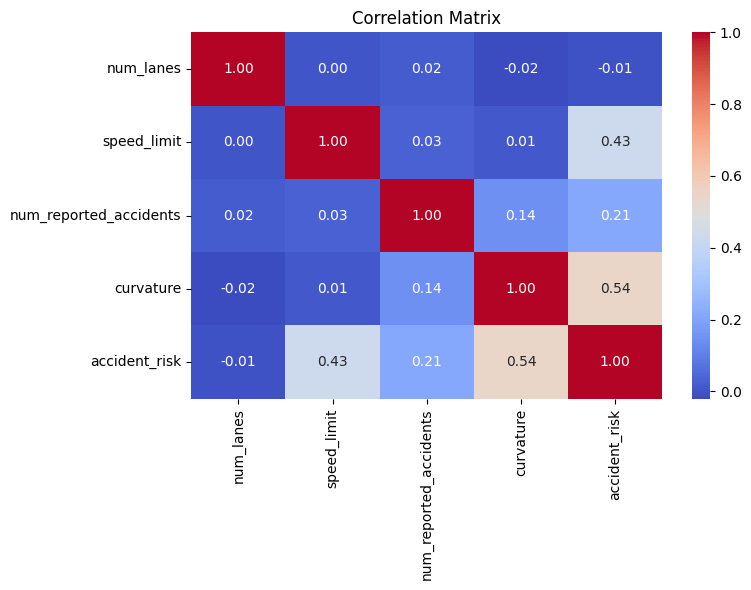

In [10]:
corr_matrix = data[['num_lanes', 'speed_limit', 'num_reported_accidents', 'curvature', 'accident_risk']].corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()

## Tratando valores faltantes

Visualizaremos la presencia de valores nulos en nuestro dataset.

<Axes: >

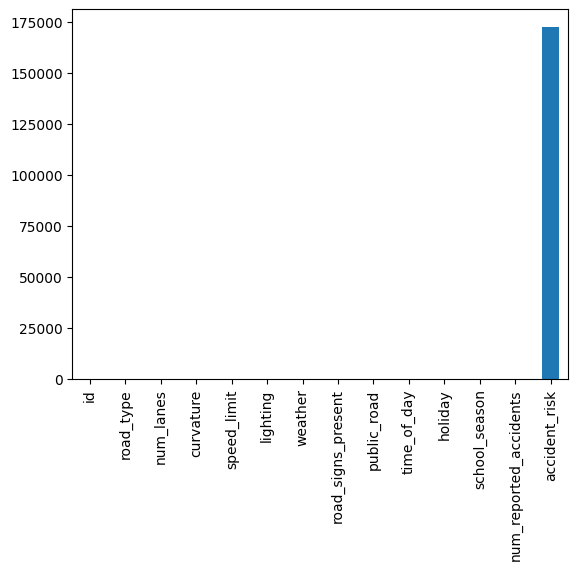

In [11]:
missing_counts = data.isnull().sum()
missing_counts.plot(kind='bar')

Y en valor porcentual...

In [12]:
missing_percent = data.isnull().mean() * 100
missing_percent.sort_values(ascending=False)

accident_risk             25.000036
id                         0.000000
road_type                  0.000000
num_lanes                  0.000000
curvature                  0.000000
speed_limit                0.000000
lighting                   0.000000
weather                    0.000000
road_signs_present         0.000000
public_road                0.000000
time_of_day                0.000000
holiday                    0.000000
school_season              0.000000
num_reported_accidents     0.000000
dtype: float64

Nótese que los valores faltantes en el dataset provienen del conjunto de prueba original (donde fueron omitidos por el autor); así que simplemente los descartaremos.


## Pipelines de preprocesamiento

La primera decisión consiste en eliminar las filas con valores faltantes, y está motivada por un criterio muy concreto: únicamente se descartan aquellas observaciones que no cuentan con un valor en *accident_risk*. Dado que esta variable es el objetivo de predicción, conservar registros sin ella no aporta información útil al proceso de entrenamiento y, por el contrario, introduciría ambigüedad operativa. El resto de las variables se mantienen intactas, evitando una pérdida innecesaria de información en los predictores.

En el pipeline de preprocesamiento se adopta una estrategia diferenciada según la naturaleza de cada variable. *curvature* se trata de forma específica porque, aunque ya está acotada, su distribución no es perfectamente uniforme y presenta concentraciones y dispersión variable a lo largo del rango. Por ello, se aplica primero un ajuste que suaviza la forma de la distribución y reduce la influencia relativa de regiones más densas, seguido de un reescalado que la coloca en una magnitud comparable al resto de las variables numéricas. Esta combinación busca que *curvature* contribuya al modelo de forma más estable, sin imponer una estructura artificial ni amplificar variaciones locales.

Las variables *road_type*, *lighting*, *weather* y *time_of_day* se transforman mediante codificación por indicadores porque representan categorías nominales expresadas como texto, sin un orden inherente entre sus valores. Este procedimiento permite preservar cada categoría como una señal independiente, evitando introducir relaciones inexistentes y facilitando que el modelo capture diferencias específicas asociadas a cada condición.

Finalmente, se opta por dejar pasar el resto de las columnas sin transformación adicional. Variables como *num_lanes*, *speed_limit* y *num_reported_accidents* ya están representadas numéricamente de manera coherente, mientras que *road_signs_present*, *public_road*, *holiday* y *school_season* son booleanas y, por tanto, directamente interpretables por el modelo. Esta decisión reduce la complejidad del preprocesamiento y evita manipulaciones innecesarias sobre variables cuya escala y codificación ya son funcionales, manteniendo un equilibrio entre preparación de datos y preservación de la estructura original de la información.


In [13]:
data = data.dropna() # Solo eliminaremos los datos sin valor de predicción en accident_risk.

preprocessing_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('pwr_curvature', make_pipeline(PowerTransformer(), StandardScaler()), ['curvature']), # Se intenta normalizar la distribución de estos datos
            ('one_hot', make_pipeline(OneHotEncoder()), ['road_type', 'lighting', 'weather', 'time_of_day']) # One Hot Encoding porque son categorías representadas con cadenas de texto
        ],
        remainder='passthrough', # num_lanes, speed_limit, road_signs_present, public_road, holiday, school_season y num_reported_accidents son categóricas pero representadas como número o booleano
    )
)

Definiremos nuestra matriz x y el vector objetivo y, así como dividir el dataset en subconjuntos de entrenamiento y de prueba; con estratificación para asegurar una buena distribución entre subconjuntos.

In [14]:
x = data[numerical_cols + categorical_cols]
y = data['accident_risk']


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

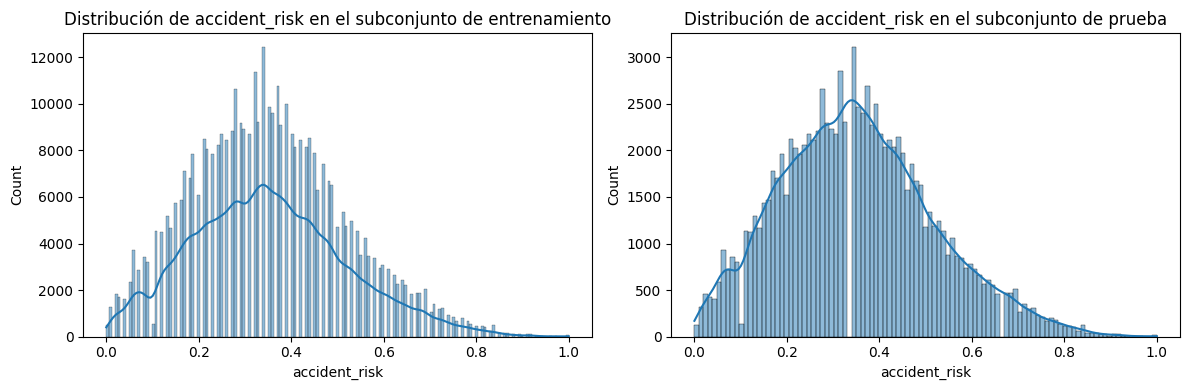

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x=y_train, ax=axs[0], kde=True)
axs[0].set_title('Distribución de accident_risk en el subconjunto de entrenamiento')
sns.histplot(x=y_test, ax=axs[1], kde=True)
axs[1].set_title('Distribución de accident_risk en el subconjunto de prueba')
fig.tight_layout()

Aplicaremos el pipeline de preprocesamiento y le ajustaremos, en el caso de los datos de entrenamiento. En el caso de los datos de prueba, solo los transformaremos sin ajuste.

In [16]:
x_train_processed = preprocessing_pipeline.fit_transform(x_train, y_train)
x_train_processed

array([[-1.2852451315679363, 0.0, 0.0, ..., False, True, 2],
       [-1.4358710561364871, 0.0, 1.0, ..., False, False, 2],
       [-0.1338404450351773, 0.0, 1.0, ..., True, True, 2],
       ...,
       [-0.4654229835222954, 1.0, 0.0, ..., True, False, 1],
       [-0.35466692002996875, 0.0, 0.0, ..., False, True, 0],
       [1.711080326843108, 0.0, 1.0, ..., False, True, 1]], dtype=object)

In [17]:
x_test_processed = preprocessing_pipeline.transform(x_test)
x_test_processed

array([[-0.539391062657212, 1.0, 0.0, ..., True, False, 1],
       [-1.3228531271180202, 1.0, 0.0, ..., True, True, 2],
       [0.5961029848608782, 0.0, 1.0, ..., True, True, 1],
       ...,
       [0.37806557760343473, 1.0, 0.0, ..., False, True, 2],
       [-0.20734952789380495, 0.0, 0.0, ..., False, True, 1],
       [0.08610622501859105, 0.0, 0.0, ..., False, True, 2]], dtype=object)

## Construyendo el modelo de regresión

Creamos nuestro modelo de regresión para predecir accident_risk

In [18]:
regression_model = make_pipeline(
    preprocessing_pipeline,
    LinearRegression()
)

Nuestro `regression_model` ahora contiene el pipeline de preprocesamiento, además del pipeline de la regresión lineal.

In [19]:
regression_model

/Users/hakkindavid/Documents/GitHub/computational-intelligence/.venv/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('pwr_curvature',
                                                                   Pipeline(steps=[('powertransformer',
                                                                                    PowerTransformer()),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['curvature']),
                                                                  ('one_hot',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder())]),
                                                                   ['road_type',
                                                                    'lighting',
                                                                    'weather',
                                                                    'time_of_day'])]))])),
                ('linearregression', LinearRegression())])

Ajustamos el modelo.

In [20]:
regression_model.fit(x_train, y_train)

/Users/hakkindavid/Documents/GitHub/computational-intelligence/.venv/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('pwr_curvature',
                                                                   Pipeline(steps=[('powertransformer',
                                                                                    PowerTransformer()),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['curvature']),
                                                                  ('one_hot',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder())]),
                                                                   ['road_type',
                                                                    'lighting',
                                                                    'weather',
                                                                    'time_of_day'])]))])),
                ('linearregression', LinearRegression())])

Intentamos una predicción.

In [21]:
y_test_pred = regression_model.predict(x_test)
y_test_pred

array([0.22057061, 0.30293452, 0.5425841 , ..., 0.36709888, 0.37767211,
       0.29416676])

Y evaluamos su desempeño.

In [22]:
x_test['accident_risk_Predicted'] = y_test_pred
x_test['accident_risk_Actual'] = y_test.values
x_test

,curvature,road_type,num_lanes,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk_Predicted,accident_risk_Actual
323417,0.34,highway,3,35,daylight,rainy,True,True,afternoon,True,False,1,0.220571,0.14
178714,0.13,highway,2,25,night,foggy,False,True,afternoon,True,True,2,0.302935,0.26
487781,0.65,rural,1,60,night,clear,True,True,evening,True,True,1,0.542584,0.53
131072,0.51,highway,1,70,daylight,clear,False,False,morning,False,False,2,0.376901,0.30
43978,0.36,highway,1,25,daylight,foggy,False,False,morning,True,False,1,0.174440,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6708,0.52,highway,4,25,dim,clear,True,True,afternoon,False,False,1,0.135930,0.14
29588,0.29,rural,4,70,night,rainy,True,False,morning,False,True,1,0.570050,0.62
94181,0.59,highway,2,45,dim,foggy,True,False,morning,False,True,2,0.367099,0.34
218988,0.43,urban,2,60,daylight,rainy,False,True,morning,False,True,1,0.377672,0.36
